# Inverse Design of a Directional Coupler (2D) with minimax and lengthscale constraints

In [1]:
import meep as mp
print(mp.__version__)
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa, tensor_jacobian_product, grad

from matplotlib import pyplot as plt
from matplotlib.patches import Circle

import nlopt
from IPython.display import Video
from typing import NamedTuple


1.27.0


In [2]:
seed = 11111#np.random.randint(100000)
np.random.seed(seed)
mp.verbosity(0)
Si = mp.Medium(index=3.4)
SiO2 = mp.Medium(index=1.44)

minimum_length = 0.15 # (μm)
eta_e = 0.75
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length,eta_e) # (μm)

waveguide_width = 0.5 # (μm)
design_region_length = 7 + (4 * filter_radius) # (μm)
design_region_width = 4 + (4 * filter_radius)  # (μm)


arm_separation = 3.5 #design_region_width - waveguide_width - 4 * filter_radius  # (μm) distance between arms center to center
waveguide_length = 2 # (μm)
pml_size = 1.0 # (μm)
resolution = 20 # (pixels/μm)

In [3]:
#filter_radius=minimum_length

eta_i = 0.5
eta_d = 1-eta_e
design_region_resolution = int(resolution) # (pixels/μm)
nf=50
frequencies = 1/np.linspace(1.5,1.6,nf) # (1/μm)

Nx = int(design_region_resolution*design_region_length)+1
Ny = int(design_region_resolution*design_region_width)+1


In [4]:
Sx = 2*pml_size + waveguide_length/2 + design_region_length+1 # cell size in X
Sy = 2*pml_size + design_region_width + 2 # cell size in Y
cell_size = mp.Vector3(Sx,Sy)

pml_layers = [mp.PML(pml_size)]

fcen = 1/1.55
width = 0.2
fwidth = width * fcen#1/1.5 - 1/1.6#width * fcen
#source_center  = [-Sx/2 + pml_size + waveguide_length/3,arm_separation/2,0]
source_size    = mp.Vector3(0,2,0)
kpoint = mp.Vector3(1,0,0)

source_center1  = [-Sx/2 + pml_size+0.2 ,arm_separation/2,0]
source_center2  = [-Sx/2 + pml_size+0.2 ,-arm_separation/2,0]


# src = mp.GaussianSource(frequency=fcen,fwidth=fwidth)
# source = [mp.EigenModeSource(src,
#                     eig_band = 1,
#                     direction=mp.NO_DIRECTION,
#                     eig_kpoint=kpoint,
#                     size = source_size,
#                     center=source_center)]

x_g = np.linspace(
    -design_region_length / 2,
    design_region_length / 2,
    Nx,
)
y_g = np.linspace(
    -design_region_width / 2,
    design_region_width / 2,
    Ny,
)
X_g, Y_g = np.meshgrid(
    x_g,
    y_g,
    sparse=True,
    indexing="ij",
)

tl_wg_mask = (X_g <= -design_region_length / 2 + filter_radius) & (
    Y_g <= (arm_separation + waveguide_width) / 2) & ( Y_g  >=(arm_separation - waveguide_width) / 2
)
                                                      
tr_wg_mask = (X_g >= design_region_length / 2 - filter_radius) & (
    Y_g <= (arm_separation + waveguide_width) / 2) & ( Y_g  >=(arm_separation - waveguide_width) / 2
)

br_wg_mask = (X_g >= design_region_length / 2 - filter_radius) & (
    Y_g <= (-arm_separation + waveguide_width) / 2) & ( Y_g  >=(-arm_separation - waveguide_width) / 2
)
                                                       
bl_wg_mask = (X_g <= -design_region_length / 2 + filter_radius) & (
    Y_g <= (-arm_separation + waveguide_width) / 2) & ( Y_g  >=(-arm_separation - waveguide_width) / 2
)                                                      
                                                     

Si_mask = tl_wg_mask | tr_wg_mask | br_wg_mask | bl_wg_mask

border_mask = (
    (X_g <= -design_region_length / 2 + filter_radius)
    | (X_g >= design_region_length / 2 - filter_radius)
    | (Y_g <= -design_region_width / 2 + filter_radius)
    | (Y_g >= design_region_width / 2 - filter_radius)
)
Air_mask = border_mask.copy()
Air_mask[Si_mask] = False


In [5]:
evaluation_history = []
cur_iter = [0]
objfunc_history=[]
epivar_history=[]

def mapping(x: np.ndarray, eta: float, beta: float) -> np.ndarray:
    """A differentiable mapping function which applies, in order,
       the following sequence of transformations to the design weights:
       (1) a bit mask for the boundary pixels, (2) convolution with a
       conic filter, and (3) projection via a hyperbolic tangent (if
       necessary).

    Args:
      x: design weights as a 1d array of size Nx*Ny.
      eta: erosion/dilation parameter for the projection.
      beta: bias parameter for the projection. A value of 0 is no projection.

    Returns:
      The mapped design weights as a 1d array.
    """
    x = npa.where(Si_mask.flatten(), 1, npa.where(Air_mask.flatten(), 0, x.flatten()))

    x = (npa.fliplr(x.reshape(Nx,Ny)) + x.reshape(Nx,Ny))/2 # up-down symmetry
    x = (npa.flipud(x.reshape(Nx,Ny)) + x.reshape(Nx,Ny))/2 # left-right symmetry

    filtered_field = mpa.conic_filter(x, filter_radius,design_region_length,design_region_width,design_region_resolution)

    if beta == 0:
        return filtered_field.flatten()

    else:
        projected_field = mpa.tanh_projection(filtered_field,beta,eta)

        return projected_field.flatten()
    




def f(x, grad):
    t = x[0]  # "dummy" parameter
    v = x[1:]  # design parameters
    if grad.size > 0:
        grad[0] = 1
        grad[1:] = 0
    return t



def c(
    result: np.ndarray, 
    x: np.ndarray, 
    gradient: np.ndarray, 
    eta: float,
    beta: float, use_epsavg: bool):
    

    """Constraint function for the epigraph formulation.

    Args:
      result: the result of the function evaluation modified in place.
      x: 1d array of size 1+Nx*Ny containing epigraph variable (first
         element) and design weights (remaining Nx*Ny elements).
      gradient: the Jacobian matrix with dimensions (1+Nx*Ny,
                2*num. wavelengths) modified in place.
      eta: erosion/dilation parameter for projection.
      beta: bias parameter for projection.
      use_epsavg: whether to use subpixel smoothing.
    """
    t = x[0]  # epigraph variable
    v = x[1:]  # design weights

    f0, dJ_du = opt([mapping(v, eta, 0 if use_epsavg else beta)])

    f0_reflection_top = f0[0]
    f0_reflection_bottom = f0[1]
    f0_transmission = f0[2]

    f0_merged = np.concatenate((f0_reflection_top,f0_reflection_bottom , f0_transmission))
    f0_merged_str = '[' + ','.join(str(ff) for ff in f0_merged) + ']'

    dJ_du_reflection_top = dJ_du[0]
    dJ_du_reflection_bottom = dJ_du[1]
    dJ_du_transmission = dJ_du[2]
     
    my_grad = np.zeros((Nx * Ny, 3 * nf))
    my_grad[:, :nf] = dJ_du_reflection_top
    my_grad[:, nf:2*nf] = dJ_du_reflection_bottom
    my_grad[:, 2*nf:] = dJ_du_transmission

    # backpropagate the gradients through mapping function
    for k in range(3 * nf):
        my_grad[:, k] = tensor_jacobian_product(mapping, 0)(
            v,
            eta,
            beta,
            my_grad[:, k],
        )

    if gradient.size > 0:
        gradient[:, 0] = -1  # gradient w.r.t. epigraph variable ("t")
        gradient[:, 1:] = my_grad.T  # gradient w.r.t. each frequency objective

    result[:] = np.real(f0_merged) - t

    objfunc_history.append(np.real(f0_merged))
    epivar_history.append(t)

    # visualize
    plt.figure()
    ax = plt.gca()
    opt.plot2D(
        False,
        ax=ax,
        plot_sources_flag=False,
        plot_monitors_flag=False,
        plot_boundaries_flag=False,
    )
    circ = Circle((2, 2), minimum_length / 2)
    ax.add_patch(circ)
    ax.axis("off")
    plt.show()

    print(
        f"iteration:, {cur_iter[0]:3d}, eta: {eta}, beta: {beta:2d}, "
        f"t: {t:.5f}, obj. func.: {f0_merged_str}"
    )

    cur_iter[0] = cur_iter[0] + 1



def glc(result: np.ndarray, x: np.ndarray, gradient: np.ndarray,
        beta: float) -> float:
    """Constraint function for the minimum linewidth.

    Args:
      result: the result of the function evaluation modified in place.
      x: 1d array of size 1+Nx*Ny containing epigraph variable (first
         element) and design weights (remaining elements).
      gradient: the Jacobian matrix with dimensions (1+Nx*Ny,
                num. wavelengths) modified in place.
      beta: bias parameter for projection.

    Returns:
      The value of the constraint function (a scalar).
    """
    t = x[0]  # dummy parameter
    v = x[1:]  # design parameters
    a1 = 1e-3  # hyper parameter (primary)
    b1 = 0  # hyper parameter (secondary)
    gradient[:, 0] = -a1

    filter_f = lambda a: mpa.conic_filter(
        a.reshape(Nx, Ny),
        filter_radius,
        design_region_length,
        design_region_width,
        design_region_resolution,
    )
    threshold_f = lambda a: mpa.tanh_projection(a, beta, eta_i)

    # hyper parameter (constant factor and exponent)
    c0 = 1e7 * (filter_radius * 1 / resolution) ** 4

    M1 = lambda a: mpa.constraint_solid(a, c0, eta_e, filter_f, threshold_f, 1)
    M2 = lambda a: mpa.constraint_void(a, c0, eta_d, filter_f, threshold_f, 1)

    g1 = grad(M1)(v)
    g2 = grad(M2)(v)

    result[0] = M1(v) - a1 * t - b1
    result[1] = M2(v) - a1 * t - b1

    gradient[0, 1:] = g1.flatten()
    gradient[1, 1:] = g2.flatten()

    t1 = (M1(v) - b1) / a1
    t2 = (M2(v) - b1) / a1

    print(f"glc:, {result[0]}, {result[1]}, {t1}, {t2}")

    return max(t1, t2)





def straight_waveguide() -> (np.ndarray, NamedTuple):
    """Computes the DFT fields from the mode source in a straight waveguide
       for use as normalization of the reflectance measurement during the
       optimization.

    Returns:
      A 2-tuple consisting of a 1d array of DFT fields and DFT fields object
      returned by `meep.get_flux_data`.
    """

 

    Sx = 2*pml_size + 3 +1 # cell size in X
    Sy = 2*pml_size + 4*waveguide_width  # cell size in Y

    refl_pt =mp.Vector3(Sx/2 - pml_size-0.1)
    stop_cond = mp.stop_when_fields_decayed(50, mp.Ez, refl_pt, 1e-8)

    cell_size = mp.Vector3(Sx,Sy)

    sources = [
        mp.EigenModeSource(
            src=mp.GaussianSource(fcen, fwidth=fwidth),
            size=source_size,
            center=mp.Vector3(x= -Sx/2 + pml_size + 0.1),
            eig_band=1,
        )
    ]

    geometry = [
        mp.Block(
            size=mp.Vector3(mp.inf, waveguide_width),
            center=mp.Vector3(),
            material=Si,
        )
    ]

    sim = mp.Simulation(
        resolution=resolution,
        default_material=mp.air,
        cell_size=cell_size,
        sources=sources,
        geometry=geometry,
        boundary_layers=pml_layers,
        k_point=mp.Vector3(),
    )

    refl_mon = sim.add_mode_monitor(
        frequencies,
        mp.ModeRegion(center= refl_pt, size=source_size),
        yee_grid=True,
    )

    sim.run(until_after_sources=stop_cond)

    res = sim.get_eigenmode_coefficients(
        refl_mon,
        [1],
    )

    coeffs = res.alpha
    input_flux = np.abs(coeffs[0, :, 0]) ** 2
    input_flux_data = sim.get_flux_data(refl_mon)

    return input_flux, input_flux_data


def dc_optimization(
        input_flux: np.ndarray,
        input_flux_data: NamedTuple,
        use_damping: bool = False,
        use_epsavg: bool = False,
        beta: float = 0) -> mpa.OptimizationProblem:
    """Sets up the adjoint optimization of the waveguide mode converter.

    Args:
      use_damping: whether to use the damping feature of `MaterialGrid`.
      use_epsavg: whether to use subpixel smoothing in `MaterialGrid`.

    Returns:
      A `meep.adjoint.OptimizationProblem` class object.
    """

    design_variables = mp.MaterialGrid(
        mp.Vector3(Nx,Ny),
        mp.air,
        Si,
        weights=np.ones((Nx, Ny)),
        beta=beta if use_epsavg else 0,
        do_averaging = True if use_epsavg else False,
        damping=0.02 * 2 * np.pi * fcen if use_damping else 0,
    )

    design_region = mpa.DesignRegion(
        design_variables,
        volume=mp.Volume(
            center=mp.Vector3(), 
            size=mp.Vector3(design_region_length, design_region_width),
            ),
        )



    geometry = [
        mp.Block(center=mp.Vector3(x=-(design_region_length+waveguide_length)/2, y=arm_separation/2), material=Si, size=mp.Vector3(waveguide_length, waveguide_width, 0)), # top left waveguide
        mp.Block(center=mp.Vector3(x=-(design_region_length+waveguide_length)/2, y=-arm_separation/2), material=Si, size=mp.Vector3(waveguide_length, waveguide_width, 0)), # bottom left waveguide
        mp.Block(center=mp.Vector3(x=(design_region_length+waveguide_length)/2, y=arm_separation/2), material=Si, size=mp.Vector3(waveguide_length, waveguide_width, 0)), # top right waveguide
        mp.Block(center=mp.Vector3(x=(design_region_length+waveguide_length)/2, y=-arm_separation/2), material=Si, size=mp.Vector3(waveguide_length, waveguide_width, 0)), # bottom right waveguide
        mp.Block(center=design_region.center, size=design_region.size, material=design_variables)
    ]



    src = mp.GaussianSource(frequency=fcen,fwidth=fwidth)
    sources = [mp.EigenModeSource(src,
                        eig_band = 1,
                        direction=mp.NO_DIRECTION,
                        eig_kpoint=kpoint,
                        size = source_size,
                        center=source_center1,
                        amplitude=1.0),
                mp.EigenModeSource(
                        src,
                        eig_band=1,
                        direction=mp.NO_DIRECTION,
                        eig_kpoint=kpoint,
                        size=source_size,
                        center=source_center2,
                        amplitude=0.0 - 1.0j
        )]



    sim = mp.Simulation(cell_size=cell_size,
                        boundary_layers=pml_layers,
                        geometry=geometry,
                        sources=sources,
                        #symmetries=[mp.Mirror(direction=mp.Y)],
                        default_material=mp.air,
                        resolution=resolution)



    mode = 1

    TE0 = mpa.EigenmodeCoefficient(sim,
            mp.Volume(center=mp.Vector3(x=Sx/2 - pml_size - 0.4, y=arm_separation/2),
                size=source_size),mode)
    TE_top = mpa.EigenmodeCoefficient(sim,
            mp.Volume(center=mp.Vector3(-Sx/2 + pml_size + 0.4,arm_separation/2,0),
                size=source_size),mode, forward=False,)
    TE_bottom = mpa.EigenmodeCoefficient(sim,
            mp.Volume(center=mp.Vector3(-Sx/2 + pml_size + 0.4,-arm_separation/2,0),
                size=source_size),mode, forward=False)
    ob_list = [TE0,TE_top,TE_bottom]

    def J_ref_top(output,top_monitor,bottom_monitor):
        power = npa.abs(top_monitor) ** 2 / input_flux
        return power

    def J_ref_bot(output,top_monitor,bottom_monitor):
        power = npa.abs(bottom_monitor) ** 2 / input_flux
        return power 

    def J_trans(output,top_monitor,bottom_monitor):
        power = npa.abs(output) ** 2 / (2 * input_flux) 
        return 1-power

    opt = mpa.OptimizationProblem(
        simulation = sim,
        objective_functions = [J_ref_top, J_ref_bot, J_trans],
        objective_arguments = ob_list,
        design_regions = [design_region],
        frequencies=frequencies
    )
    return opt




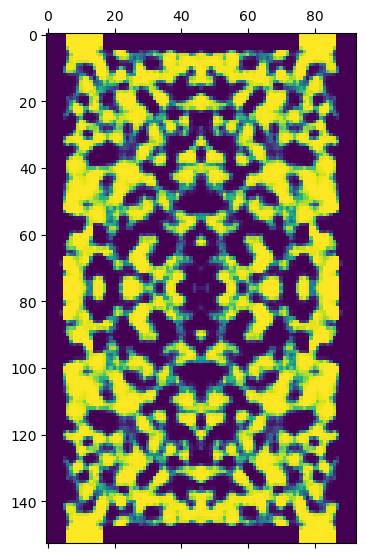

In [6]:
plt.matshow(mapping(np.random.rand(Nx,Ny),0.5,64).reshape(Nx,Ny))

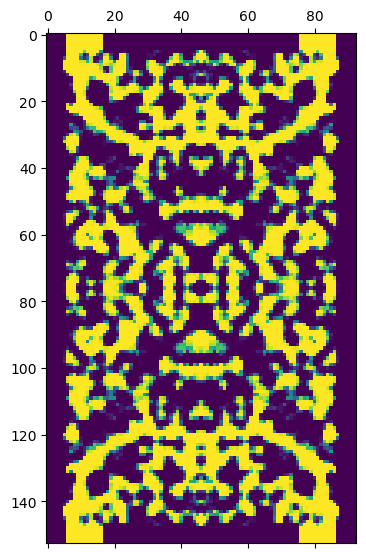

In [7]:
plt.matshow(mapping(np.random.rand(Nx,Ny),0.5,128).reshape(Nx,Ny))

In [8]:
input_flux, input_flux_data = straight_waveguide()

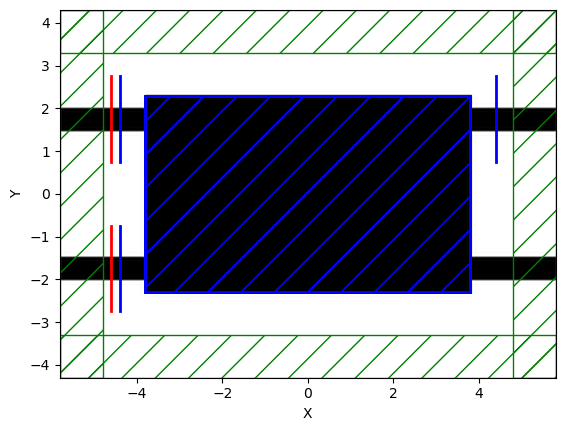

In [9]:
op=dc_optimization(input_flux,input_flux_data, beta=64)
op.plot2D(True)

## Gradient visualization

In [ ]:
x0 = 0.5*np.ones((Nx,Ny)) #+ np.random.normal(loc=mean, scale=std, size=(Nx,Ny))

#just for the same of a boundary value
x0=np.where(x0>1,1,x0)
x0=np.where(x0<0,0,x0)

#x0 = np.random.rand(Nx,Ny)
f0, g0 = op([mapping(x0,0.5,2)])

In [ ]:
np.shape(g0.T)

In [ ]:
plt.figure()
print(g0.shape)
plt.imshow(np.rot90(g0[:,0].reshape(Nx,Ny)))
plt.colorbar()

In [ ]:
backprop_gradient = tensor_jacobian_product(mapping,0)(x0,0.5,2,g0[:,0])
plt.imshow(np.rot90(backprop_gradient.reshape(Nx,Ny)))
plt.colorbar()

## For the phase, 2 things must be considered: 
1. The top input and top output are inphase
2. The top input and top output had a phase difference of pi/2 with the bottom waveguide

That's why we use "Phase injected topology optimization" ( Read more here: https://pubs.acs.org/doi/abs/10.1021/acsphotonics.2c01016)

Starting forward run...
Starting forward run...
Starting adjoint run...


/home/satadrudas/anaconda3/envs/meep/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Calculating gradient...


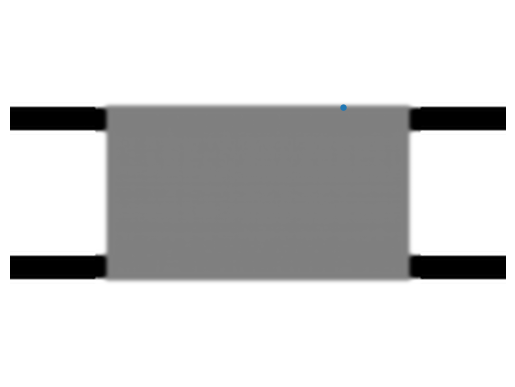

iteration:,   0, eta: 0.5, beta:  8, t: 1.02563, obj. func.: [0.05348849466468561,0.054111484831244894,0.052776661247562744,0.04965656389921036,0.045425517406142896,0.04065389714551445,0.03576046761974186,0.03107098460819749,0.026835991414518336,0.023262184752851866,0.020545527100303888,0.01886121111001369,0.018317088375160873,0.01890001279875414,0.020405929397504605,0.02235725363907059,0.024043580804390424,0.024870354247504816,0.024735282821307547,0.02403105631762868,0.023466647129046198,0.02339094867067061,0.023636718290292354,0.024006756642399082,0.024156520708643638,0.023743995794890393,0.022722427865722164,0.021326320229780368,0.019874713904005338,0.0186222909366516,0.017729522833474457,0.01729353414322799,0.017381072893722396,0.01804537627197044,0.019328205814752555,0.021249293860108702,0.023781142200173015,0.02681188553141495,0.03011220245295506,0.033342187061665855,0.036148507651809936,0.0383639410003668,0.040128459588903605,0.04157065256428135,0.04225657249502954,0.04131652658

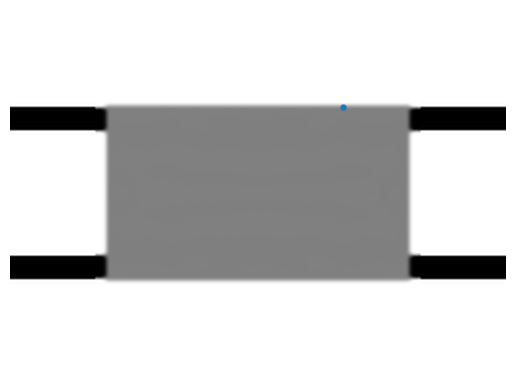

iteration:,   1, eta: 0.5, beta:  8, t: 0.97615, obj. func.: [0.054824101447596564,0.05581903173096319,0.054710922393843404,0.05158110019473248,0.04714739987528948,0.04207485960126519,0.03685902634579157,0.03186815039595924,0.027370407091524156,0.023577707948112925,0.02068406173733988,0.018856239067412513,0.01819054430199477,0.0186651257045279,0.020075318290242734,0.02195578210665978,0.023624599784458918,0.024527185954077987,0.02458657240672574,0.024153216993052708,0.023844559333704864,0.02397536718482908,0.024382351570714667,0.024851533934660597,0.025034321497648976,0.02461138900837231,0.023563696393428958,0.02214270105821195,0.020672109313306996,0.019405222074367175,0.01850042494144161,0.018053680047412292,0.018131222530389995,0.018786086799353317,0.02006007478393172,0.021973111722643955,0.024497455385739487,0.02751941585686623,0.030805545478795222,0.03401131227521411,0.03678481407954993,0.03897429305320402,0.04074376783853975,0.04223215402195505,0.042994984271115894,0.04213297830426

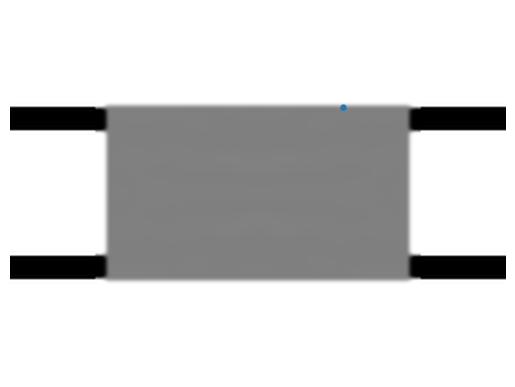

iteration:,   2, eta: 0.5, beta:  8, t: 0.96508, obj. func.: [0.05618035255685829,0.057607099942169435,0.05676003387220849,0.053605675383800774,0.04891882636618791,0.043483935438130526,0.03788922467182618,0.0325515187060617,0.02775783636424614,0.023724135383633656,0.02063986562882966,0.018659407633286447,0.017864083438593286,0.018222366736786563,0.01953014953444901,0.02133750083888086,0.022995305301665544,0.023995471020869408,0.024295127906554845,0.024200127597801706,0.024213334751780342,0.02459930308374907,0.02519700538284774,0.02577578165498598,0.0259890853947995,0.025550128623882444,0.024474274749045663,0.023031659929378966,0.021548797919264156,0.02027485628745506,0.01936425611374852,0.018910489309820446,0.01897879986179819,0.01962168382308795,0.02088097226155277,0.02277689616130747,0.025281426217882635,0.028278964203530946,0.03153121496433752,0.03468854136029674,0.037400732072847935,0.0395339035305563,0.04127973263760896,0.042790765979257774,0.043616067862175346,0.04282956052780077

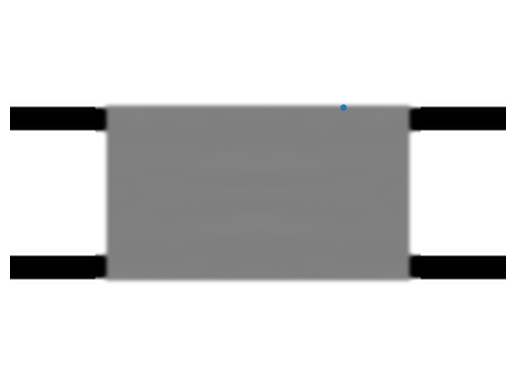

iteration:,   3, eta: 0.5, beta:  8, t: 0.95547, obj. func.: [0.05625994687205315,0.058029916618547873,0.05739906596842368,0.05426255775878949,0.049449107634568584,0.0438330768720713,0.038061717087201755,0.032574502216019714,0.027657341999081677,0.023519267855029544,0.020339026989547322,0.018258891317121658,0.017350357494509434,0.01758157785410613,0.01876498584596303,0.020485485562272625,0.022135966719859516,0.02322449991136189,0.023709016796992066,0.02389446574487934,0.024236993101823933,0.024922500865860214,0.025725566326636053,0.02638342274658521,0.026571097027220426,0.026054048261580108,0.024891878999533365,0.023376520121179228,0.021835279692388482,0.02051192787933415,0.01955503977820635,0.019055597372181363,0.019077227842176872,0.019672503180465036,0.020884376427095758,0.022736276346629013,0.025204696910218705,0.028178313262975256,0.031420598587971055,0.03458036631569917,0.03730587613619411,0.03946705616335936,0.04126466813994882,0.042859566627966035,0.04380797863773102,0.04317783

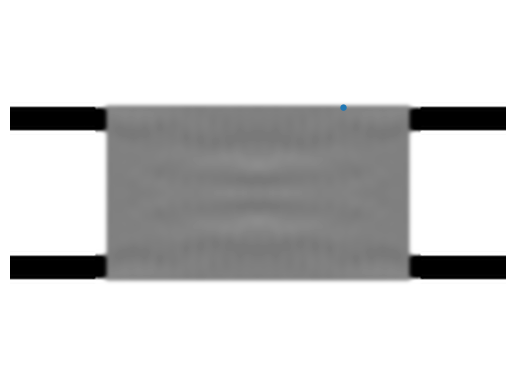

iteration:,   4, eta: 0.5, beta:  8, t: 0.88003, obj. func.: [0.04878519659361116,0.05204676043424914,0.05193171804428247,0.04858085533549291,0.04336523859957344,0.037598061463020895,0.032045777263703244,0.02702160866534077,0.02262085770177908,0.01888598460688383,0.015861419971491895,0.013595874919619399,0.012143585979356494,0.011552304111759315,0.011814359915812882,0.012795585570169975,0.014197797107130879,0.01564840182740465,0.016920658736667007,0.01802857357173121,0.019099365858492066,0.02017942330960187,0.021062491286482087,0.0214326871049364,0.021127618909850116,0.020232186926488607,0.01898721238616267,0.017645991030222925,0.016397284490806498,0.015365354213779638,0.014636405237527897,0.014277323009656109,0.014344132554479076,0.014885052758022793,0.01593948705954013,0.017526357043883212,0.0196140871984692,0.022075022441695437,0.02465643070738412,0.027039110336417205,0.029041240504656472,0.030847298501706505,0.03286143630195303,0.03510552141851645,0.03691169041322507,0.037282467199

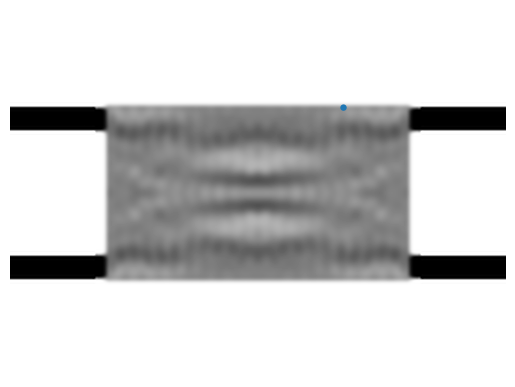

iteration:,   5, eta: 0.5, beta:  8, t: 0.38614, obj. func.: [0.02450069414059777,0.026594793301549326,0.029979341566400825,0.03503048542909267,0.041322702668881925,0.047864526888963796,0.05346648442234968,0.057165352591387955,0.05854476400507537,0.05783234963940853,0.055777780731912995,0.05341997639652096,0.051825442318079756,0.0518511927841276,0.053939983124729654,0.057922251793890274,0.06282551311957969,0.06697563181250026,0.0688391033782126,0.06816802934896334,0.06599764644591052,0.06340132322634372,0.06069780946627396,0.057717853315761035,0.05429995602003622,0.05047123444463916,0.04639213497370612,0.042253347795551364,0.0382354489798707,0.0345389417798549,0.03144239522886433,0.029301639912164324,0.028421431851585084,0.028824285865131985,0.030108881724184543,0.03163630346059488,0.03304182858250549,0.03470431521624968,0.03773799392123046,0.0434668341142028,0.05272952740375181,0.06539670813033664,0.0801375573629329,0.09427009881346725,0.10387202515210973,0.10518308972534751,0.0975893

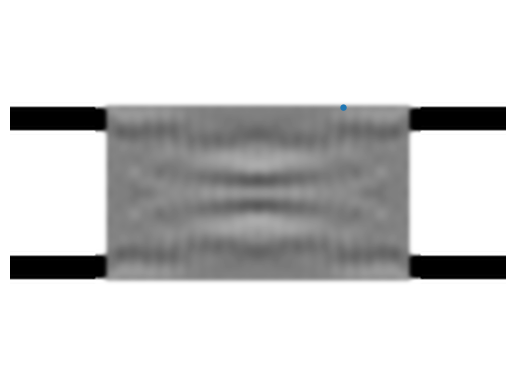

iteration:,   6, eta: 0.5, beta:  8, t: 0.55336, obj. func.: [0.061804828089567436,0.07208201217094072,0.08019836062252375,0.0867853875575421,0.09230527563600316,0.09684452896982329,0.10016116672082807,0.10186907856493901,0.10167424245035543,0.09958774686691478,0.09604120707637663,0.09183842752866819,0.08793340246297349,0.08502184905253181,0.08295262416648631,0.08033869996558718,0.07528658237998978,0.06744545317414793,0.059429317196306994,0.05471875684464809,0.054178592264245824,0.056164006777988634,0.05867699434841329,0.060377787995021734,0.060585606200316486,0.05910091826511185,0.05607468976623112,0.05190792690278961,0.04714917576000617,0.04240351631405374,0.03826700257289363,0.03530520645026012,0.034047721424918055,0.034937563457929255,0.03813773467195064,0.04327281342889242,0.049497626588768724,0.05606089483803423,0.06269612204335132,0.0694290419748872,0.07620908154131972,0.08266284805668016,0.08788990832686427,0.0902140339349705,0.0873996944337907,0.0785130825769942,0.066278326270

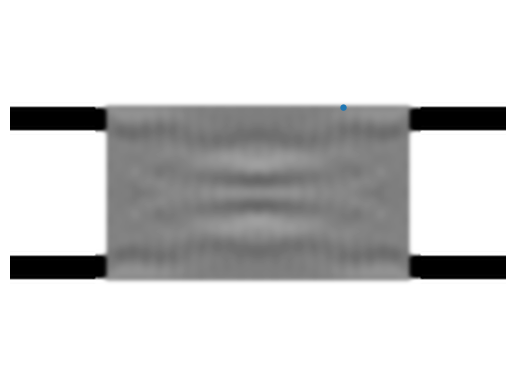

iteration:,   7, eta: 0.5, beta:  8, t: 0.66147, obj. func.: [0.02712516549395151,0.03329242698665833,0.03867707947515121,0.04265135377284778,0.04489917555497432,0.045469070198337284,0.04460814178369081,0.042586397363452676,0.039616842924181446,0.03586811599442279,0.03152335057691708,0.02682481896486104,0.022065918851572597,0.01754395994756005,0.013515966888869257,0.01018162860011101,0.007680507471310397,0.006065402927664255,0.005273474919185611,0.00526590964398542,0.006209341039906279,0.008107098979186074,0.010462774300551902,0.01270459835456489,0.014496490812367958,0.015679882159609845,0.0161847896196889,0.0160003979840042,0.01517401431471077,0.013813255080795792,0.012079558702767808,0.010168709585032763,0.008282586966392193,0.006602599694840631,0.005274781776470603,0.004414146885675989,0.004135256093823067,0.004604960038464284,0.006061732726096536,0.008691123733663307,0.012393926267076954,0.0167362244756836,0.021148228790288454,0.025085867898535272,0.028024054713059,0.02938274187589

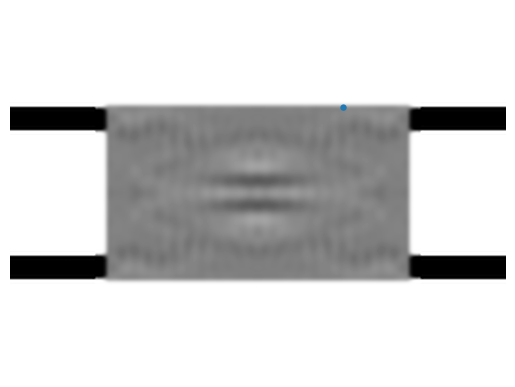

iteration:,   8, eta: 0.5, beta:  8, t: 0.48238, obj. func.: [0.012431193590322707,0.016191563214422992,0.02021910044598832,0.02371132389972771,0.02596495184884615,0.026625668200230716,0.025727689429222492,0.023561925475188462,0.020514793864713585,0.016978836306589667,0.013322434229798417,0.009864665794116717,0.006846596429255559,0.004417791313536822,0.002646400507304777,0.0015428960966146603,0.0010676889187827244,0.0010915605052122484,0.0013751101159083837,0.001716664229056275,0.002082883554273573,0.0024885574833408406,0.0028978151868326828,0.003254772336014105,0.003522343512848887,0.0036856508775589655,0.003744280382691558,0.0037063501789149043,0.0035818331877428425,0.0033766590129645445,0.0030917557467008043,0.0027276681259839927,0.0022910646715392506,0.001801041326889132,0.0012932592158280663,0.0008178029062835986,0.000425915589044292,0.0001519700215825336,1.3836958888081531e-05,4.668033278799315e-05,0.00032495948032590496,0.0009131058983513316,0.001796118279339671,0.00284775484348

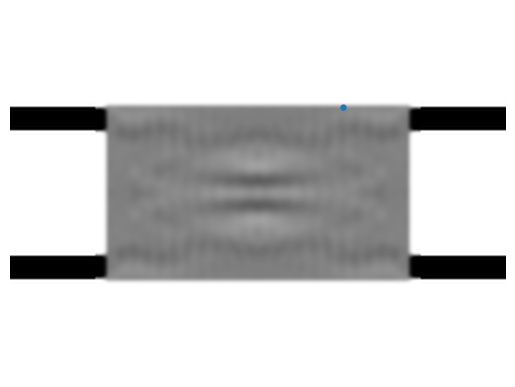

iteration:,   9, eta: 0.5, beta:  8, t: 0.53178, obj. func.: [0.021191215725456836,0.025737405928120568,0.029253349711734763,0.03124765042204084,0.0315810365602104,0.030404925757594726,0.028045199204981688,0.024885115892238675,0.021281717660833782,0.0175331669463647,0.013882996632544407,0.010532115112786837,0.007640715284685332,0.005322755446254939,0.003638659746647124,0.002583086310278409,0.0020652675845633196,0.0019053197444699698,0.0019249361097212153,0.002126314082689322,0.0026486196039832302,0.0034782417499623864,0.004427409249017494,0.005300304196967785,0.005962503842652861,0.006334882670923798,0.006381289410060912,0.006103492048905369,0.005537893373647571,0.004750921797862194,0.003831763306917309,0.0028818859161136136,0.002000812349679991,0.0012707779231068133,0.0007437995249812285,0.00043556313809690563,0.00033249766306320635,0.0004233591882119234,0.0007581776632540355,0.001469061172253477,0.00265504419949845,0.00424356143468983,0.006010381161228719,0.007661238996684901,0.00884

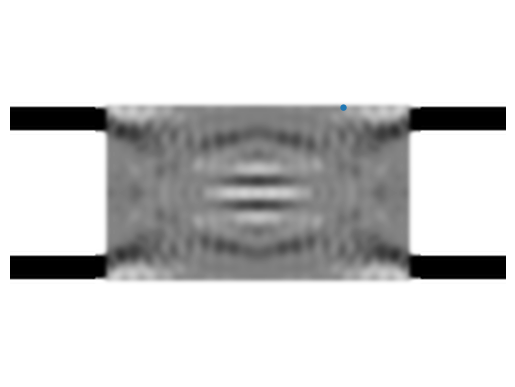

iteration:,  10, eta: 0.5, beta:  8, t: 0.17121, obj. func.: [0.040144705518372834,0.042670779517743465,0.05185995198639101,0.06418300555976461,0.0782313343737867,0.09340125854395834,0.10895060454519123,0.12377881430994851,0.13658703633114724,0.14618022169570494,0.1517460184181242,0.15300909709678487,0.15012027434813102,0.1432260802465495,0.13224662172760324,0.11735072042199608,0.09948739996329233,0.08032273570356224,0.061766292158395956,0.045488596563164264,0.03267256118187184,0.024030274482992494,0.019901484871786786,0.02017703320812807,0.023993837258351525,0.029598175174800966,0.03517489338532517,0.04047019434602735,0.04674622330059314,0.05478442266804811,0.06393574279056052,0.07277488759379656,0.08006140844778994,0.08516479984409621,0.08795414661402438,0.0885331839644746,0.08710167787768981,0.08393770111353954,0.0793937058656799,0.07387341057820804,0.06780740811110926,0.06163801443006906,0.055802153967018,0.050687615194315076,0.04655152772041051,0.04344044484189749,0.04118307105509

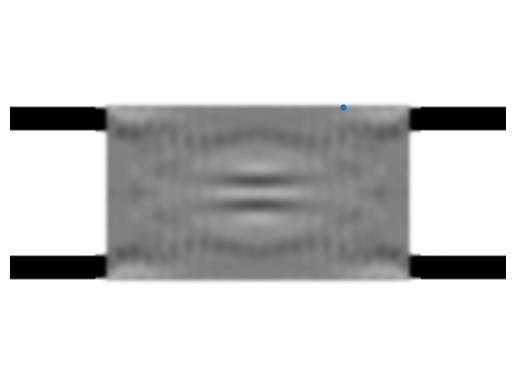

iteration:,  11, eta: 0.5, beta:  8, t: 0.39072, obj. func.: [0.017978440622803477,0.025290036050371497,0.03184809721742321,0.036882366696403844,0.040127375182675215,0.04178289230525783,0.04230673483220136,0.042170021013263864,0.04171474197156825,0.04113784151654463,0.04049551604259943,0.03964143090569211,0.03816635748454574,0.03550255478090378,0.031320859846097227,0.026059269258323713,0.020843249789114823,0.016700307127560775,0.014100878660500749,0.013025403984152398,0.013316832194844046,0.015156712198457392,0.01857810816752393,0.022999536287904784,0.027666677357637347,0.03191169343220822,0.03522084729802891,0.03730860464180853,0.03817801918061381,0.03811352076898845,0.03759332170729945,0.03715459702556352,0.037255396979948265,0.038143512009293085,0.03969355336315482,0.04120899826640434,0.04147831748728127,0.03959746013734395,0.03600693025261896,0.03217719807003989,0.029363195457024475,0.028040594339350307,0.02810012864719771,0.029171196646237515,0.030812191879547805,0.032550127602111

In [10]:
input_flux, input_flux_data = straight_waveguide()

algorithm = nlopt.LD_MMA

n = Nx * Ny

# initial design parameters
x = np.ones((n,)) * 0.5 #+ np.random.normal(loc=mean, scale=std, size=(n,))
x[Si_mask.flatten()] = 1.0  # set the edges of waveguides to silicon
x[Air_mask.flatten()] = 0.0  # set the other edges to SiO2

# lower and upper bounds for design weights
lb = np.zeros((n,))
lb[Si_mask.flatten()] = 1.0
ub = np.ones((n,))
ub[Air_mask.flatten()] = 0.0

# insert epigraph variable initial value (arbitrary) and bounds into the
# design array. the actual value is determined by the objective and
# constraint functions below.
x = np.insert(x, 0, 1.2)
lb = np.insert(lb, 0, -np.inf)
ub = np.insert(ub, 0, +np.inf)

objfunc_history = []
epivar_history = []
cur_iter = [0]

beta_thresh = 64 # threshold beta above which to use subpixel smoothing
betas = [8, 16, 32, 64, 128]
max_evals = [30, 30, 30, 30, 30]
tol_epi = np.array([1e-4] * 3 * len(frequencies))  # R_top, R_bot, 1-T
tol_lw = np.array([1e-8] *2 )  # line width, line spacing

input_flux, input_flux_data = straight_waveguide()

for beta, max_eval in zip(betas, max_evals):
    solver = nlopt.opt(algorithm, n + 1)
    solver.set_lower_bounds(lb)
    solver.set_upper_bounds(ub)
    solver.set_min_objective(f)
    solver.set_maxeval(max_eval)
    solver.set_param("dual_ftol_rel", 1e-7)
    solver.add_inequality_mconstraint(
        lambda rr, xx, gg: c(
            rr,
            xx,
            gg,
            eta_i,
            beta,
            False if beta < beta_thresh else True,
            
        ),
        tol_epi,
    )


    opt = dc_optimization(
        input_flux, 
        input_flux_data,
        True,  # use_damping
        False if beta < beta_thresh else True,  # use_epsavg
        beta,
    )
    # apply the minimum linewidth constraint
    # only in the final epoch to an initial
    # binary design from the previous epoch.
    if beta == betas[-1]:
        res = np.zeros(2)
        grd = np.zeros((2, n + 1))
        t = glc(res, x, grd, beta)
        solver.add_inequality_mconstraint(
            lambda rr, xx, gg: glc(
                rr,
                xx,
                gg,
                beta,
            ),
            tol_lw,
        )

    # execute a single forward run before the start of each
    # epoch and manually set the initial epigraph variable to
    # slightly larger than the largest value of the objective
    # function over the six wavelengths and the lengthscale
    # constraint (final epoch only).
    t0,_ = opt(
        [
            mapping(
                x[1:],
                eta_i,
                beta if beta < beta_thresh else 0,
            ),
        ],
        need_gradient=False,
    )
    #t0 = np.concatenate((t0[0], t0[1], t0[2]))
    x[0] = np.amax(t0)
    x[0] = 1.05 * (max(x[0], t) if beta == betas[-1] else x[0])

    x[:] = solver.optimize(x)

    optimal_design_weights = mapping(
        x[1:],
        eta_i,
        beta,
    ).reshape(Nx, Ny)

    # save the unmapped weights and a bitmap image
    # of the design weights at the end of each epoch.
    fig, ax = plt.subplots()
    ax.imshow(
        optimal_design_weights,
        cmap="binary",
        interpolation="none",
    )
    ax.set_axis_off()
    if mp.am_master():
        fig.savefig(
            f"optimal_design_beta{beta}.png",
            dpi=150,
            bbox_inches="tight",
        )
        # save the final (unmapped) design as a 2d array in CSV format
        np.savetxt(
            f"unmapped_design_weights_beta{beta}.csv",
            x[1:].reshape(Nx, Ny),
            fmt="%4.2f",
            delimiter=",",
        )

In [ ]:
#################################################
#SAVE THE design_region (x)
#################################################

np.save("design_dc_minimax_lc2.npy",x[1:])

In [ ]:
plt.matshow(x[1:].reshape(Nx,Ny))

In [ ]:
epivar_history=np.arrar(epivar_history)
np.save("epivar_history_lc2.npy",epivar_history)
plt.figure()
plt.plot(epivar_history,'o-')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Epivar')
plt.show()


In [ ]:
evaluation_history=np.array(evaluation_history)
np.save("evaluation_history2.npy",evaluation_history)

plt.figure()
plt.plot(10*np.log10(1-evaluation_history),'o-')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Insertion Loss (dB)')
plt.show()

In [ ]:
lb = 1 - np.min(evaluation_history, axis=1)
ub = 1 - np.max(evaluation_history, axis=1)
mean = 1 - np.mean(evaluation_history, axis=1)

num_iters = lb.size

plt.figure()
plt.fill_between(
    np.arange(1, num_iters + 1), 10 * np.log10(lb), 10 * np.log10(ub), alpha=0.3
)
plt.plot(10 * np.log10(mean), "o-")
plt.grid(True)
plt.xlabel("Iteration")
plt.ylabel("Average Insertion Loss (dB)")
plt.show()

In [ ]:

src = mp.GaussianSource(frequency=fcen,fwidth=fwidth)
source = [mp.EigenModeSource(src,
                    eig_band = 1,
                    direction=mp.NO_DIRECTION,
                    eig_kpoint=kpoint,
                    size = source_size,
                    center=source_center1)]



sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=source,
                    #symmetries=[mp.Mirror(direction=mp.Y)],
                    default_material=mp.air,
                    resolution=resolution)



mode = 1

TE0 = mpa.EigenmodeCoefficient(sim,
        mp.Volume(center=mp.Vector3(x=-(Sx/2 - pml_size - 0.4), y=arm_separation/2),
            size=mp.Vector3(y=2)),mode)
TE_top = mpa.EigenmodeCoefficient(sim,
        mp.Volume(center=mp.Vector3(-(-Sx/2 + pml_size + 0.4),arm_separation/2,0),
            size=mp.Vector3(y=arm_separation/2)),mode)
TE_bottom = mpa.EigenmodeCoefficient(sim,
        mp.Volume(center=mp.Vector3(-(-Sx/2 + pml_size + 0.4),-arm_separation/2,0),
            size=mp.Vector3(y=arm_separation/2)),mode)
ob_list = [TE0,TE_top,TE_bottom]

def J(output,top_source,bottom_source):
    power = npa.abs(output) ** 2 / (npa.abs(top_source)**2 + npa.abs(bottom_source)**2) #npa.abs(output/top_source) ** 2 + npa.abs(output/bottom_source) ** 2 
    return 1-power#npa.mean(power)

opt = mpa.OptimizationProblem(
    simulation = sim,
    objective_functions = J,
    objective_arguments = ob_list,
    design_regions = [design_region],
    frequencies=frequencies
)
opt.plot2D(True)

In [ ]:
cur_beta=256
f0, dJ_du = opt([mapping(x[1:],eta_i,cur_beta)],need_gradient = False)
frequencies = opt.frequencies
source_coef, top_coef, bottom_ceof = opt.get_objective_arguments()

top_profile = np.abs(top_coef/source_coef) ** 2
bottom_profile = np.abs(bottom_ceof/source_coef) ** 2


In [ ]:
plt.figure()
plt.plot(1/frequencies,top_profile*100,'-o' ,label = 'Top Arm')
plt.plot(1/frequencies,bottom_profile*100,'--o',label = 'Bottom Arm')
plt.legend()
plt.grid(True)
plt.xlabel('Wavelength (microns)')
plt.ylabel('Power Splitting Ratio (%)')
#plt.ylim(46.5,50)
plt.show()

In [ ]:
plt.figure()
plt.plot(1/frequencies,1-(np.abs(top_coef) ** 2 + np.abs(bottom_ceof) ** 2)/np.abs(source_coef) ** 2,'-o' ,label = 'Insertion loss')
plt.legend()
plt.grid(True)
plt.xlabel('Wavelength (microns)')
plt.ylabel('Insertion loss')
#plt.ylim(46.5,50)
plt.show()

In [ ]:
plt.figure()
plt.plot(1/frequencies,(np.abs(top_coef) ** 2 / np.abs(bottom_ceof) ** 2) ** 2,'-o' ,label = 'Output ration')
plt.legend()
plt.grid(True)
plt.xlabel('Wavelength (microns)')
plt.ylabel('Output power ration')
#plt.ylim(46.5,50)
plt.show()

In [ ]:
src = mp.ContinuousSource(frequency=1 / 1.55, fwidth=fwidth)
source = [
    mp.EigenModeSource(
        src,
        eig_band=1,
        direction=mp.NO_DIRECTION,
        eig_kpoint=kpoint,
        size=source_size,
        center=source_center1,
    )
]
opt.sim.change_sources(source)
opt.sim.run(until=500)
opt.sim.plot2D(fields=mp.Ez)

In [ ]:
sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=source,
                    #symmetries=[mp.Mirror(direction=mp.Y)],
                    default_material=mp.air,
                    resolution=resolution)

In [ ]:
plt.figure(dpi=100)
sim.plot2D()
plt.show()

In [ ]:
sim.run(until=300)


In [ ]:
plt.figure(dpi=120)
sim.plot2D(fields=mp.Ez)
plt.show()

In [ ]:
sim.reset_meep()
f = plt.figure(dpi=100)
Animate = mp.Animate2D(fields=mp.Ez, f=f, realtime=False, normalize=True)
plt.close()

In [ ]:
sim.run(mp.at_every(1, Animate), until=150)
plt.close()

In [ ]:
filename = "dc_2d_15x4_1s.mp4"
Animate.to_mp4(10, filename)

In [ ]:
Video(filename)


In [ ]:
src = mp.ContinuousSource(frequency=1 / 1.55, fwidth=fwidth)
sources = [mp.EigenModeSource(src,
                    eig_band = 1,
                    direction=mp.NO_DIRECTION,
                    eig_kpoint=kpoint,
                    size = source_size,
                    center=source_center1,
                    amplitude=1.0),
            mp.EigenModeSource(
                    src,
                    eig_band=1,
                    direction=mp.NO_DIRECTION,
                    eig_kpoint=kpoint,
                    size=source_size,
                    center=source_center2,
                    amplitude=0.0 - 1.0j
    )]

In [ ]:
sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    #symmetries=[mp.Mirror(direction=mp.Y)],
                    default_material=mp.air,
                    resolution=resolution)

plt.figure(dpi=100)
sim.plot2D()
plt.show()

In [ ]:
sim.run(until=300)


In [ ]:
plt.figure(dpi=120)
sim.plot2D(fields=mp.Ez)
plt.show()

In [ ]:
sim.reset_meep()
f = plt.figure(dpi=100)
Animate = mp.Animate2D(fields=mp.Ez, f=f, realtime=False, normalize=True)
plt.close()

In [ ]:
sim.run(mp.at_every(1, Animate), until=300)
plt.close()

In [ ]:
filename = "dc_2d_15x4_2s.mp4"
Animate.to_mp4(10, filename)

In [ ]:
Video(filename)
